<a href="https://colab.research.google.com/github/Akshatb848/UNIFIED-MENTOR/blob/main/Cybersecurity_Web_Threats_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cybersecurity Project — Suspicious Web Threat Interactions

Colab-ready notebook. Upload your CSV, set `DATA_PATH`, and run all cells.

Dataset shape: (282, 16)

Dtypes:
bytes_in                             int64
bytes_out                            int64
creation_time          datetime64[ns, UTC]
end_time               datetime64[ns, UTC]
src_ip                              object
src_ip_country_code                 object
protocol                            object
response.code                        int64
dst_port                             int64
dst_ip                              object
rule_names                          object
observation_name                    object
source.meta                         object
source.name                         object
time                   datetime64[ns, UTC]
detection_types                     object
dtype: object

Head:
   bytes_in  bytes_out             creation_time                  end_time  \
0      5602      12990 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
1     30912      18186 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
2     28506      13468 

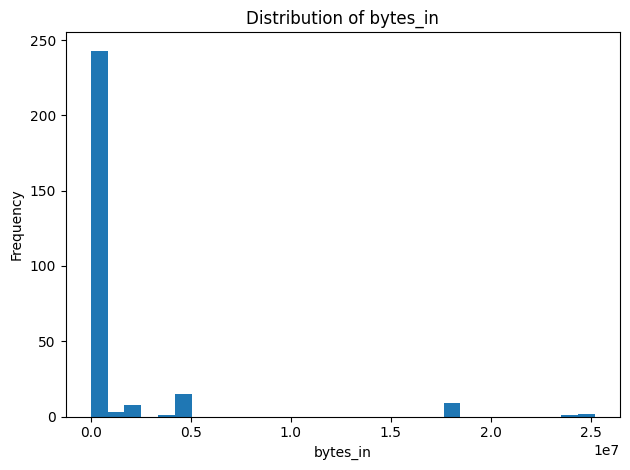

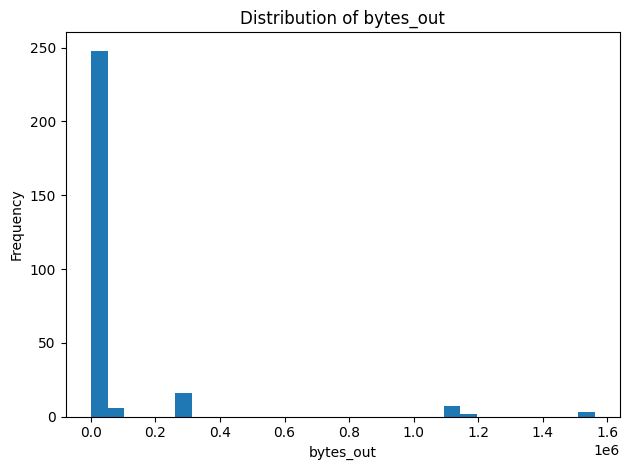

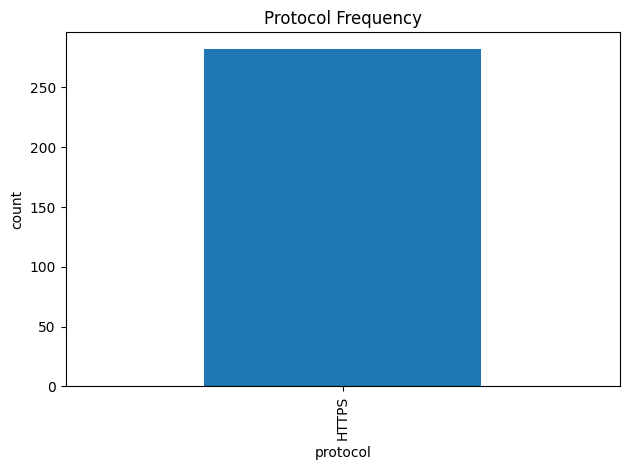

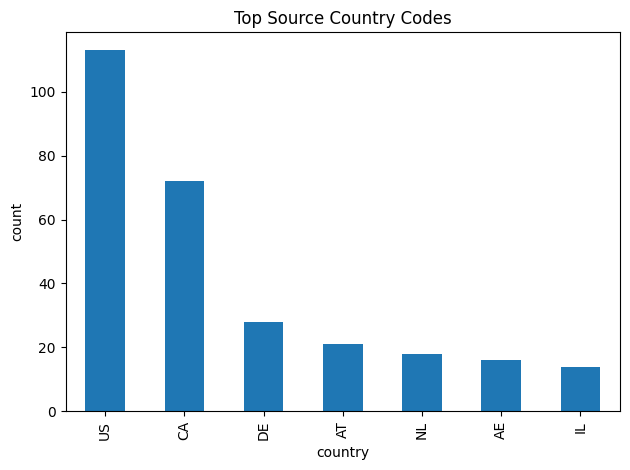

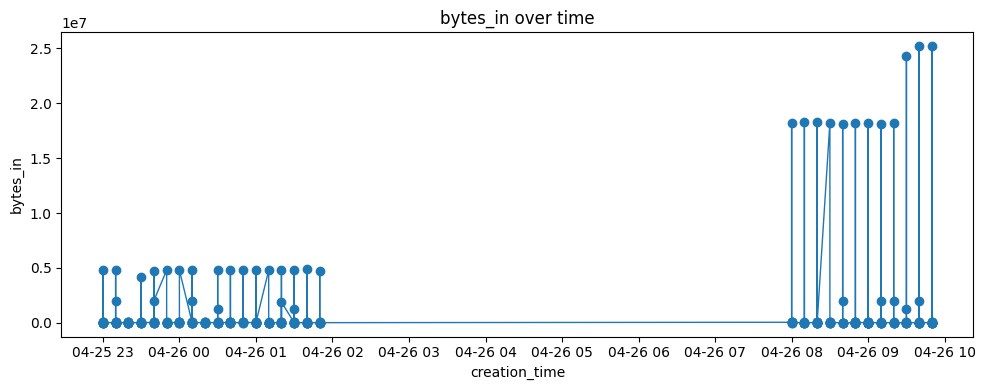

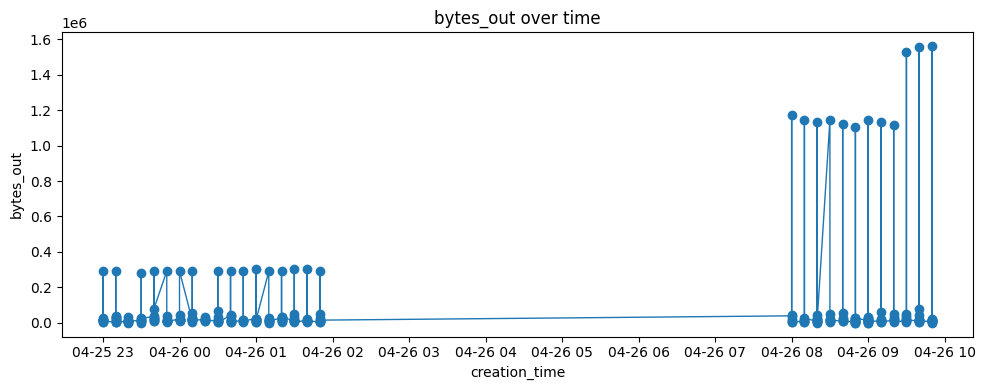


Engineered feature preview:
   session_duration_s  total_bytes  bytes_diff  in_out_ratio  in_rate_bps  \
0               600.0        18592       -7388      0.431255     9.336667   
1               600.0        49098       12726      1.699769    51.520000   
2               600.0        41974       15038      2.116573    47.510000   
3               600.0        44824       16268      2.139375    50.910000   
4               600.0        20418       -7366      0.469767    10.876667   

   out_rate_bps  total_rate_bps  hour  
0     21.650000       30.986667    23  
1     30.310000       81.830000    23  
2     22.446667       69.956667    23  
3     23.796667       74.706667    23  
4     23.153333       34.030000    23  


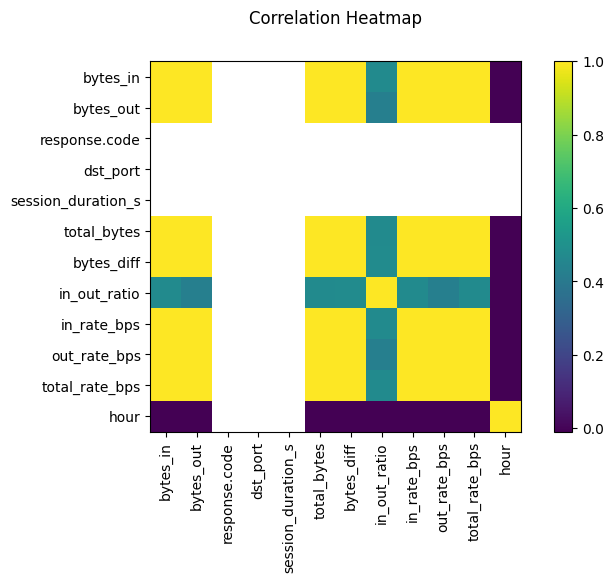


[Info] Supervised training skipped — not enough label diversity (only one class or too few samples).

IsolationForest anomaly rate: 5.32%


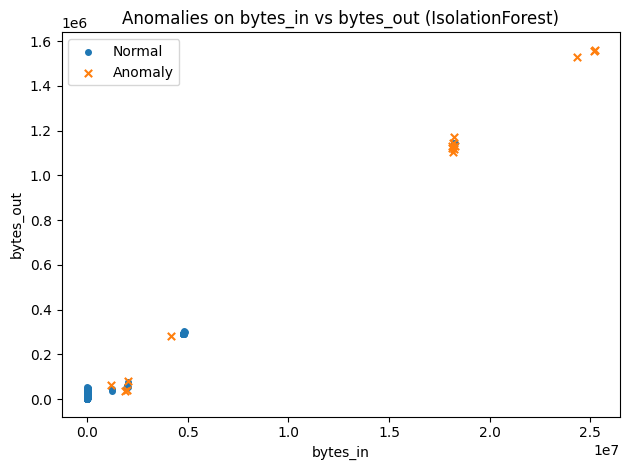


Processed dataset saved to: /content/processed_web_threats.csv

Summary:
- Rows: 282, Columns: 25
- Detected anomalies (iso_anomaly==1): 15
- Features used: ['bytes_in', 'bytes_out', 'session_duration_s', 'total_bytes', 'bytes_diff', 'in_out_ratio', 'in_rate_bps', 'out_rate_bps', 'total_rate_bps', 'hour']
- Label present: detection_types → binary is_waf_rule (1) vs other (0)


In [2]:
# ==============================================================
# Cybersecurity Project — Suspicious Web Threat Interactions
# Google Colab–ready (T4 GPU optional, CPU fine)
# ==============================================================

# ✅ STEP 0 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io, textwrap, json, math, warnings
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest

warnings.filterwarnings("ignore")

# ==============================================================
# ✅ STEP 1 — Load dataset
# Upload your CSV in Colab (Files sidebar) or mount Drive.
# Change DATA_PATH accordingly.
# ==============================================================

# Example (direct upload to /content):
DATA_PATH = "/content/CloudWatch_Traffic_Web_Attack.csv"  # <— adjust if needed

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)

# ==============================================================
# ✅ STEP 2 — Basic cleaning & typing
# ==============================================================

def to_dt(s):
    try:
        return pd.to_datetime(s, utc=True, errors="coerce")
    except Exception:
        return pd.NaT

for col in ["creation_time","end_time","time"]:
    if col in df.columns:
        df[col] = df[col].apply(to_dt)

# Normalize column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Peek & types
print("\nDtypes:")
print(df.dtypes)
print("\nHead:")
print(df.head(3))

# ==============================================================
# ✅ STEP 3 — EDA (Exploratory Data Analysis)
# ==============================================================

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Helper to safely plot a histogram if column exists
def plot_hist(col, bins=30):
    if col in df.columns:
        vals = df[col].dropna().values
        if vals.size > 0:
            plt.figure()
            plt.hist(vals, bins=bins)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

# Distributions
plot_hist("bytes_in", bins=30)
plot_hist("bytes_out", bins=30)

# Protocol frequency
if "protocol" in df.columns:
    vc = df["protocol"].value_counts()
    if not vc.empty:
        plt.figure()
        vc.plot(kind="bar")
        plt.title("Protocol Frequency")
        plt.xlabel("protocol")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

# Country frequency (top 15)
if "src_ip_country_code" in df.columns:
    vc = df["src_ip_country_code"].value_counts().head(15)
    if not vc.empty:
        plt.figure()
        vc.plot(kind="bar")
        plt.title("Top Source Country Codes")
        plt.xlabel("country")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

# Time series of bytes over creation_time (if present)
if "creation_time" in df.columns:
    for col in ["bytes_in", "bytes_out"]:
        if col in df.columns:
            tmp = df[["creation_time", col]].dropna().sort_values("creation_time")
            if not tmp.empty:
                plt.figure(figsize=(10,4))
                plt.plot(tmp["creation_time"], tmp[col], marker="o", linewidth=1)
                plt.title(f"{col} over time")
                plt.xlabel("creation_time")
                plt.ylabel(col)
                plt.tight_layout()
                plt.show()

# ==============================================================
# ✅ STEP 4 — Feature Engineering
# ==============================================================

df_fe = df.copy()

# Session duration (seconds)
if {"creation_time","end_time"}.issubset(df_fe.columns):
    df_fe["session_duration_s"] = (df_fe["end_time"] - df_fe["creation_time"]).dt.total_seconds()
else:
    df_fe["session_duration_s"] = np.nan

# Ensure bytes columns exist
for c in ["bytes_in","bytes_out"]:
    if c not in df_fe.columns:
        df_fe[c] = np.nan

# Core traffic features
df_fe["total_bytes"] = df_fe["bytes_in"] + df_fe["bytes_out"]
df_fe["bytes_diff"]  = df_fe["bytes_in"] - df_fe["bytes_out"]

# Safe ratios/rates
def safe_div(num, den):
    return np.where(den == 0, np.nan, num/den)

df_fe["in_out_ratio"]  = safe_div(df_fe["bytes_in"], df_fe["bytes_out"])
df_fe["in_rate_bps"]   = safe_div(df_fe["bytes_in"], df_fe["session_duration_s"])
df_fe["out_rate_bps"]  = safe_div(df_fe["bytes_out"], df_fe["session_duration_s"])
df_fe["total_rate_bps"]= safe_div(df_fe["total_bytes"], df_fe["session_duration_s"])

# Hour-of-day feature
if "creation_time" in df_fe.columns:
    df_fe["hour"] = df_fe["creation_time"].dt.hour
else:
    df_fe["hour"] = np.nan

print("\nEngineered feature preview:")
print(df_fe[["session_duration_s","total_bytes","bytes_diff","in_out_ratio","in_rate_bps","out_rate_bps","total_rate_bps","hour"]].head())

# ==============================================================
# ✅ STEP 5 — Correlation Heatmap (fixed for Matplotlib 3.8+)
# ==============================================================

num_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df_fe[num_cols].corr()
    plt.figure(figsize=(8,6))
    # FIXED: use imshow (not matshow with fignum)
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap", y=1.08)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("\n[Info] Skipping heatmap — need at least 2 numeric columns.")

# ==============================================================
# ✅ STEP 6 — Label creation (if available)
# ==============================================================

y = None
if "detection_types" in df_fe.columns:
    # label == 1 when detection_types contains 'waf_rule'
    y = (df_fe["detection_types"].astype(str).str.lower() == "waf_rule").astype(int)

# Feature matrix
feature_cols = [
    "bytes_in","bytes_out","session_duration_s","total_bytes","bytes_diff",
    "in_out_ratio","in_rate_bps","out_rate_bps","total_rate_bps","hour"
]
X = df_fe[feature_cols].fillna(0.0)

# ==============================================================
# ✅ STEP 7 — Supervised Modeling (if labels are diverse)
# ==============================================================

if y is not None and y.nunique() >= 2 and min(y.value_counts()) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    models = {
        "Logistic Regression": LogisticRegression(max_iter=200),
        "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    }

    for name, model in models.items():
        pipe = Pipeline([("scale", StandardScaler()), ("clf", model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        try:
            probs = pipe.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, probs)
        except Exception:
            probs = None
            auc = np.nan

        acc = accuracy_score(y_test, preds)
        pr, rc, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary", zero_division=0)
        print(f"\nModel: {name}")
        print(f"Accuracy: {acc:.4f} | Precision: {pr:.4f} | Recall: {rc:.4f} | F1: {f1:.4f} | AUC: {auc if not np.isnan(auc) else 'NA'}")
        print(classification_report(y_test, preds, digits=3, zero_division=0))
else:
    print("\n[Info] Supervised training skipped — not enough label diversity (only one class or too few samples).")

# ==============================================================
# ✅ STEP 8 — Unsupervised Anomaly Detection (Isolation Forest)
# ==============================================================

iso = Pipeline([
    ("scale", StandardScaler()),
    ("iso", IsolationForest(n_estimators=300, contamination=0.05, random_state=42))
])
pred = iso.fit_predict(X)
df_fe["iso_anomaly"] = (pred == -1).astype(int)
anomaly_rate = df_fe["iso_anomaly"].mean() * 100.0
print(f"\nIsolationForest anomaly rate: {anomaly_rate:.2f}%")

# Scatter visualization: bytes_in vs bytes_out
if {"bytes_in","bytes_out"}.issubset(df_fe.columns):
    plt.figure()
    normal = df_fe[df_fe["iso_anomaly"]==0]
    anoms  = df_fe[df_fe["iso_anomaly"]==1]
    plt.scatter(normal["bytes_in"], normal["bytes_out"], s=16, label="Normal")
    if not anoms.empty:
        plt.scatter(anoms["bytes_in"], anoms["bytes_out"], s=28, marker="x", label="Anomaly")
    plt.legend()
    plt.title("Anomalies on bytes_in vs bytes_out (IsolationForest)")
    plt.xlabel("bytes_in")
    plt.ylabel("bytes_out")
    plt.tight_layout()
    plt.show()

# ==============================================================
# ✅ STEP 9 — Save processed dataset
# ==============================================================

out_path = "/content/processed_web_threats.csv"
df_fe.to_csv(out_path, index=False)
print(f"\nProcessed dataset saved to: {out_path}")

# ==============================================================
# ✅ STEP 10 — Summary
# ==============================================================

print("\nSummary:")
print(f"- Rows: {df_fe.shape[0]}, Columns: {df_fe.shape[1]}")
print(f"- Detected anomalies (iso_anomaly==1): {(df_fe['iso_anomaly']==1).sum()}")
print("- Features used:", feature_cols)
if y is not None:
    print("- Label present: detection_types → binary is_waf_rule (1) vs other (0)")
else:
    print("- No label column found; ran unsupervised only.")
